TV-Regularized Sparse-View CT Reconstruction (Multiple Projectors)
==================================================================

This example demonstrates solution of a sparse-view CT reconstruction
problem with isotropic total variation (TV) regularization

  $$\mathrm{argmin}_{\mathbf{x}} \; (1/2) \| \mathbf{y} - A \mathbf{x}
  \|_2^2 + \lambda \| C \mathbf{x} \|_{2,1} \;,$$

where $A$ is the X-ray transform (the CT forward projection operator),
$\mathbf{y}$ is the sinogram, $C$ is a 2D finite difference operator, and
$\mathbf{x}$ is the desired image. The solution is computed and compared
for all three 2D CT projectors available in scico.

In [1]:
import numpy as np

import jax

from xdesign import Foam, discrete_phantom

import scico.numpy as snp
from scico import functional, linop, loss, metric, plot
from scico.linop.xray import Parallel2dProjector, XRayTransform, astra, svmbir
from scico.optimize.admm import ADMM, LinearSubproblemSolver
from scico.util import device_info
plot.config_notebook_plotting()

Create a ground truth image.

In [2]:
N = 512  # phantom size
np.random.seed(1234)
x_gt = discrete_phantom(Foam(size_range=[0.075, 0.0025], gap=1e-3, porosity=1), size=N)
x_gt = jax.device_put(x_gt)

Define CT geometry and construct array of (approximately) equivalent projectors.

In [3]:
n_projection = 45  # number of projections
angles = np.linspace(0, np.pi, n_projection)  # evenly spaced projection angles
projectors = {
    "astra": astra.XRayTransform(x_gt.shape, 1, N, angles - np.pi / 2.0),  # astra
    "svmbir": svmbir.XRayTransform(x_gt.shape, 2 * np.pi - angles, N),  # svmbir
    "scico": XRayTransform(Parallel2dProjector((N, N), angles, det_count=N)),  # scico
}

Solve the same problem using the different projectors.

In [4]:
print(f"Solving on {device_info()}")
y, x_rec, hist = {}, {}, {}
noise = np.random.normal(size=(n_projection, N)).astype(np.float32)
for p in ("astra", "svmbir", "scico"):
    print(f"\nSolving with {p} projector")
    A = projectors[p]
    y[p] = A @ x_gt + 2.0 * noise  # sinogram

    # Set up ADMM solver object.
    λ = 2e0  # L1 norm regularization parameter
    ρ = 5e0  # ADMM penalty parameter
    maxiter = 25  # number of ADMM iterations
    cg_tol = 1e-4  # CG relative tolerance
    cg_maxiter = 25  # maximum CG iterations per ADMM iteration

    # The append=0 option makes the results of horizontal and vertical
    # finite differences the same shape, which is required for the L21Norm,
    # which is used so that g(Cx) corresponds to isotropic TV.
    C = linop.FiniteDifference(input_shape=x_gt.shape, append=0)
    g = λ * functional.L21Norm()
    f = loss.SquaredL2Loss(y=y[p], A=A)
    x0 = snp.clip(A.T(y[p]), 0, 1.0)

    # Set up the solver.
    solver = ADMM(
        f=f,
        g_list=[g],
        C_list=[C],
        rho_list=[ρ],
        x0=x0,
        maxiter=maxiter,
        subproblem_solver=LinearSubproblemSolver(cg_kwargs={"tol": cg_tol, "maxiter": cg_maxiter}),
        itstat_options={"display": True, "period": 5},
    )

    # Run the solver.
    solver.solve()
    hist[p] = solver.itstat_object.history(transpose=True)
    x_rec[p] = snp.clip(solver.x, 0, 1.0)

Solving on CPU

Solving with astra projector


Iter  Time      Objective  Prml Rsdl  Dual Rsdl  CG It  CG Res   
-----------------------------------------------------------------
   0  5.04e+00  5.067e+03  1.267e+02  3.859e+00     25  4.894e-04


   5  2.52e+01  3.003e+04  3.939e+01  8.877e+01     19  9.421e-05


  10  3.31e+01  3.389e+04  2.213e+01  1.455e+01      0  9.598e-05


  15  4.05e+01  3.468e+04  1.688e+01  2.749e+01      8  9.894e-05


  20  4.47e+01  3.502e+04  3.781e+01  4.642e+01      9  8.536e-05


  24  4.81e+01  3.522e+04  1.183e+01  5.261e+00      0  9.422e-05

Solving with svmbir projector


Iter  Time      Objective  Prml Rsdl  Dual Rsdl  CG It  CG Res   
-----------------------------------------------------------------
   0  1.61e+01  5.919e+03  1.253e+02  5.991e+00     25  5.328e-04


   5  8.79e+01  3.272e+04  3.783e+01  8.436e+01     17  8.241e-05


  10  1.20e+02  3.662e+04  2.699e+01  4.670e+01     13  9.227e-05


  15  1.42e+02  3.746e+04  1.358e+01  6.594e+00      2  8.150e-05


  20  1.66e+02  3.747e+04  1.858e+01  3.658e+01     12  8.725e-05


  24  1.80e+02  3.759e+04  2.469e+01  1.684e+01      0  9.652e-05

Solving with scico projector


Iter  Time      Objective  Prml Rsdl  Dual Rsdl  CG It  CG Res   
-----------------------------------------------------------------
   0  3.59e+00  5.879e+03  1.335e+02  6.991e+00     25  5.620e-04


   5  2.08e+01  3.130e+04  4.416e+01  8.836e+01     21  9.430e-05


  10  2.90e+01  3.388e+04  3.310e+01  4.722e+01     12  8.132e-05


  15  3.35e+01  3.465e+04  4.416e+01  5.207e+01     11  8.849e-05


  20  3.64e+01  3.518e+04  1.319e+01  6.882e+00      0  9.950e-05


  24  4.05e+01  3.516e+04  1.307e+01  5.833e+00      0  9.278e-05


Compare sinograms.

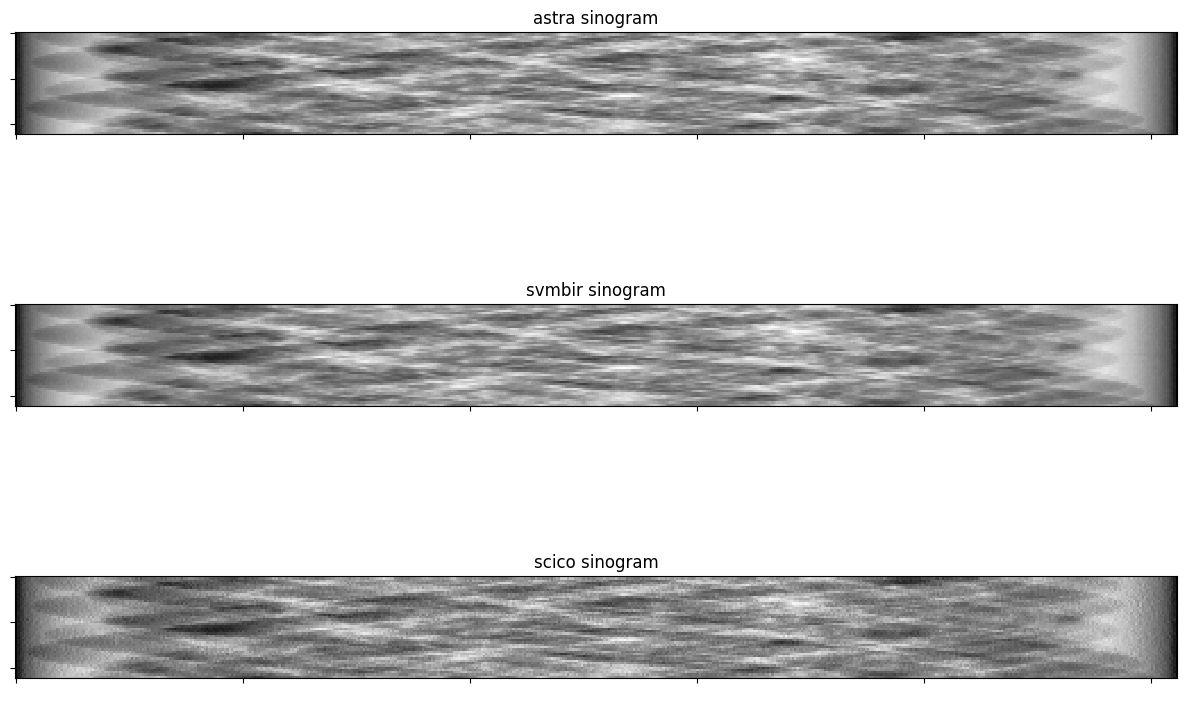

In [5]:
fig, ax = plot.subplots(nrows=3, ncols=1, figsize=(15, 10))
for idx, name in enumerate(projectors.keys()):
    plot.imview(y[name], title=f"{name} sinogram", cbar=None, fig=fig, ax=ax[idx])
fig.show()

Plot convergence statistics.

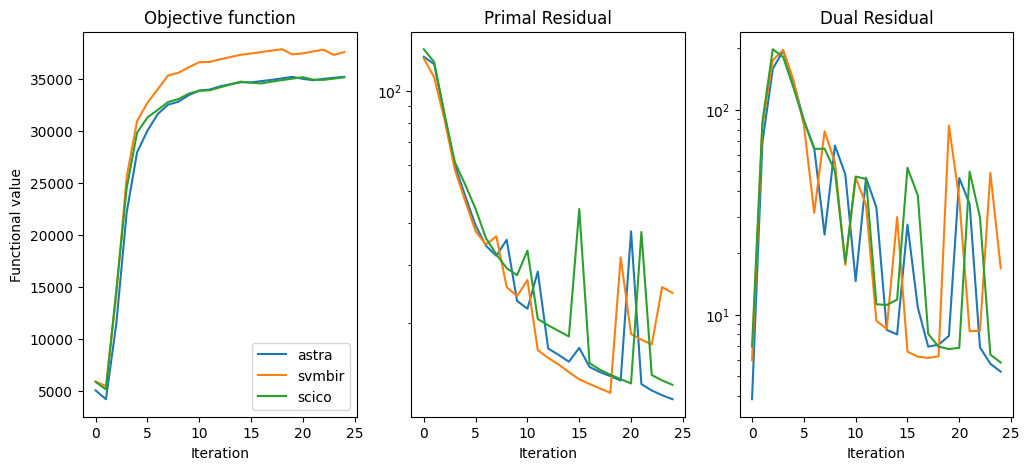

In [6]:
fig, ax = plot.subplots(nrows=1, ncols=3, figsize=(12, 5))
plot.plot(
    np.vstack([hist[p].Objective for p in projectors.keys()]).T,
    title="Objective function",
    xlbl="Iteration",
    ylbl="Functional value",
    lgnd=projectors.keys(),
    fig=fig,
    ax=ax[0],
)
plot.plot(
    np.vstack([hist[p].Prml_Rsdl for p in projectors.keys()]).T,
    ptyp="semilogy",
    title="Primal Residual",
    xlbl="Iteration",
    fig=fig,
    ax=ax[1],
)
plot.plot(
    np.vstack([hist[p].Dual_Rsdl for p in projectors.keys()]).T,
    ptyp="semilogy",
    title="Dual Residual",
    xlbl="Iteration",
    fig=fig,
    ax=ax[2],
)
fig.show()

Show the recovered images.

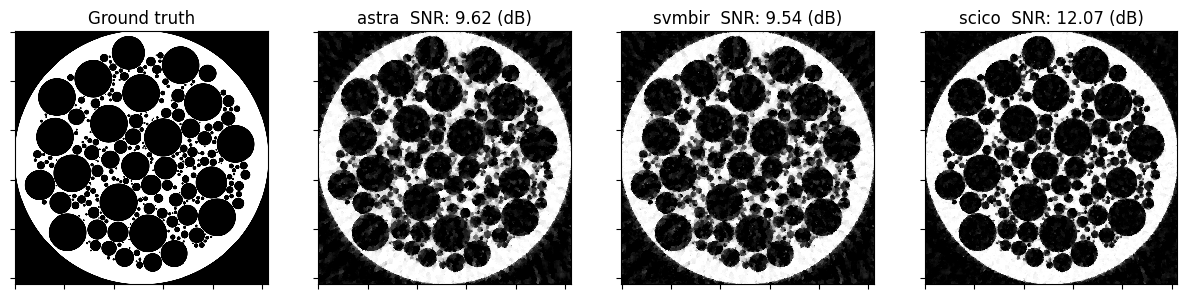

In [7]:
fig, ax = plot.subplots(nrows=1, ncols=4, figsize=(15, 5))
plot.imview(x_gt, title="Ground truth", fig=fig, ax=ax[0])
for n, p in enumerate(projectors.keys()):
    plot.imview(
        x_rec[p],
        title="%s  SNR: %.2f (dB)" % (p, metric.snr(x_gt, x_rec[p])),
        fig=fig,
        ax=ax[n + 1],
    )
fig.show()